# Brain Imaging Analysis and Reporting System

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, EfficientNetB0, MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from PIL import Image
from ultralytics import YOLO
from fpdf import FPDF

# YOLO model
yolo_model = YOLO('yolov8n.pt')

def load_and_preprocess_images(directory, target_size=(224, 224)):
    X, y = [], []
    class_folders = os.listdir(directory)
    class_folders.sort()

    for class_index, class_folder in enumerate(class_folders):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                try:
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, target_size)
                    X.append(image)
                    y.append(class_index)
                except Exception as e:
                    print(f"Error loading {image_path}: {e}")
    
    X = np.array(X)
    y = np.array(y)
    return X, y

# Load and preprocess images
path = "archive/Training"
X, y = load_and_preprocess_images(path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to create a simple CNN model
def create_cnn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# Function to create and train a model (VGG16, EfficientNet, MobileNet)
def train_model(base_model, X_train, y_train, X_test, y_test, num_classes):
    base_model.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=7, validation_data=(X_test, y_test))
    return model


2024-10-21 19:43:57.688604: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Train VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_model_final = train_model(vgg16_model, X_train, y_train, X_test, y_test, len(os.listdir(path)))


Epoch 1/7


2024-10-21 19:44:06.835266: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 687762432 exceeds 10% of free system memory.
2024-10-21 19:44:07.940551: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2024-10-21 19:44:08.065497: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


  1/143 ━━━━━━━━━━━━━━━━━━━━ 7:59 3s/step - accuracy: 0.2812 - loss: 13.8252

2024-10-21 19:44:10.562796: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2024-10-21 19:44:10.684788: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


143/143 ━━━━━━━━━━━━━━━━━━━━ 515s 4s/step - accuracy: 0.6785 - loss: 5.8477 - val_accuracy: 0.8661 - val_loss: 0.4227
Epoch 2/7
143/143 ━━━━━━━━━━━━━━━━━━━━ 524s 4s/step - accuracy: 0.8085 - loss: 0.5486 - val_accuracy: 0.8924 - val_loss: 0.3756
Epoch 3/7
143/143 ━━━━━━━━━━━━━━━━━━━━ 557s 4s/step - accuracy: 0.8356 - loss: 0.4582 - val_accuracy: 0.9204 - val_loss: 0.2979
Epoch 4/7
143/143 ━━━━━━━━━━━━━━━━━━━━ 542s 4s/step - accuracy: 0.8493 - loss: 0.3951 - val_accuracy: 0.9125 - val_loss: 0.3069
Epoch 5/7
143/143 ━━━━━━━━━━━━━━━━━━━━ 518s 4s/step - accuracy: 0.8595 - loss: 0.3939 - val_accuracy: 0.9274 - val_loss: 0.2411
Epoch 6/7
143/143 ━━━━━━━━━━━━━━━━━━━━ 503s 4s/step - accuracy: 0.8812 - loss: 0.3313 - val_accuracy: 0.9169 - val_loss: 0.2833
Epoch 7/7
143/143 ━━━━━━━━━━━━━━━━━━━━ 506s 4s/step - accuracy: 0.8825 - loss: 0.3402 - val_accuracy: 0.9160 - val_loss: 0.3571


In [ ]:
# Train EfficientNet model
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
efficientnet_model_final = train_model(efficientnet_model, X_train, y_train, X_test, y_test, len(os.listdir(path)))

In [ ]:
# Train MobileNet model
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet_model_final = train_model(mobilenet_model, X_train, y_train, X_test, y_test, len(os.listdir(path)))

In [4]:
# Evaluate the CNN models
vgg16_model_final.evaluate(X_test, y_test)
#efficientnet_model_final.evaluate(X_test, y_test)
#mobilenet_model_final.evaluate(X_test, y_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.9082 - loss: 0.3481


[0.3570597469806671, 0.9160104990005493]

In [5]:
# Function to preprocess image
def preprocess_image(image):
    image = image.resize((224, 224))  # Resize to match model input
    image = np.array(image)
    image = image / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict tumor presence using CNN
def predict_tumor(image, model):
    processed_image = preprocess_image(image)
    prediction = model.predict(processed_image)
    predicted_class = np.argmax(prediction, axis=1)
    return "Tumor Detected" if predicted_class == 1 else "No Tumor"

# Function to detect tumor using YOLO and draw bounding box
def detect_and_draw_bounding_box(image_path):
    results = yolo_model.predict(image_path, save=False, show=False)
    image = cv2.imread(image_path)
    boxes = results[0].boxes

    if boxes:  # Check if any boxes are detected
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].numpy().astype(int)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        return image, True  # Return the image with bounding box and detection status
    else:
        return image, False



In [6]:
# Function to handle user image input
def handle_user_image_input(image_path, model):
    try:
        image = Image.open(image_path)
        result = predict_tumor(image, model)
        print(f"Prediction: {result}")
        
        if result == "Tumor Detected":
            image_with_box, tumor_detected = detect_and_draw_bounding_box(image_path)
            return result, image_with_box if tumor_detected else None
        else:
            return result, None
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None



In [7]:
# Function to generate a PDF report
def generate_pdf_report(image_path, prediction, image_with_box=None):
    pdf = FPDF()
    pdf.add_page()
    
    pdf.set_font("Arial", size=16)
    pdf.cell(200, 10, txt="Brain Tumor Detection Report", ln=True, align="C")

    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, txt=f"Prediction: {prediction}", ln=True, align="L")

    if prediction == "Tumor Detected" and image_with_box is not None:
        output_image_path = "output_image_with_box.jpg"
        cv2.imwrite(output_image_path, image_with_box)
        pdf.image(output_image_path, x=10, y=30, w=100)
    else:
        pdf.image(image_path, x=10, y=30, w=100)
    
    output_path = "tumor_detection_report.pdf"
    pdf.output(output_path)
    print(f"PDF report generated: {output_path}")



In [ ]:
# Example usage
image_path = "Te-me_0027.jpg"  # Replace with actual image path
prediction, image_with_box = handle_user_image_input(image_path, vgg16_model_final)
if prediction:
    generate_pdf_report(image_path, prediction, image_with_box)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Prediction: Tumor Detected



In [1]:
# Generate confusion matrix and classification report
y_pred = vgg16_model_final.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Use class names instead of numbers in confusion matrix and classification report
class_names = os.listdir(path)  # Get class names from directory
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix with class names
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Generate classification report using class names
report = classification_report(y_test, y_pred_classes, target_names=class_names)
print(report)

with open("classification_report.txt", "w") as f:
    f.write(report)

NameError: name 'vgg16_model_final' is not defined

In [ ]:
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Prediction: No Tumor
PDF report generated: tumor_detection_report.pdf
36/36 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step


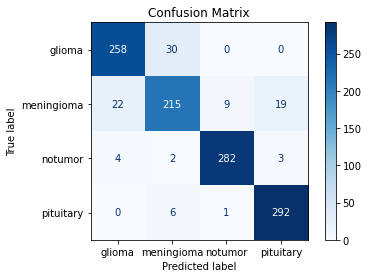

              precision    recall  f1-score   support

      glioma       0.91      0.90      0.90       288
  meningioma       0.85      0.81      0.83       265
     notumor       0.97      0.97      0.97       291
   pituitary       0.93      0.98      0.95       299

    accuracy                           0.92      1143
   macro avg       0.91      0.91      0.91      1143
weighted avg       0.92      0.92      0.92      1143

Precision: 0.92
Recall: 0.92
F1 Score: 0.92
143/143 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.9641 - loss: 0.1314
36/36 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.9082 - loss: 0.3481
Training Loss: 0.1246
Training Accuracy: 96.32%
Validation Loss: 0.3571
Validation Accuracy: 91.60%


In [9]:


# Calculate precision, recall, and F1 score for each class
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")




In [ ]:
# Calculate and display overall accuracy and loss for training and validation
train_loss, train_accuracy = vgg16_model_final.evaluate(X_train, y_train)
val_loss, val_accuracy = vgg16_model_final.evaluate(X_test, y_test)

print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")